In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import autoencoder


In [2]:
#Function to load all the images
def Dataloader(loc,channels):
    all_img = []
    all_class = []
    all_mean = []
    for i in range(1,31):
        mean = []
        for j in range(1,22):
            if(channels==1):
                img = cv2.imread(loc+str(i).zfill(2)+"_"+str(j).zfill(2)+".png",cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(loc+str(i).zfill(2)+"_"+str(j).zfill(2)+".png")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            all_img.append(img.flatten()/np.linalg.norm(img))
            mean.append(img.flatten()/np.linalg.norm(img))
            all_class.append(i)
        all_mean.append(np.array(mean).mean(axis=0))
        
    return np.array(all_img).T,np.array(all_class), np.array(all_mean).T
            


In [3]:
#Funtion which returns k eigenvectors using PCA
def PCA_eigenvectors(X,k):
    mean = X.mean(axis=1)
    C = (X.T-mean.T)@(X.T-mean.T).T/X.shape[1]
    U,D,VT = np.linalg.svd(C)
    w = X@VT.T
    W = w/np.linalg.norm(w,axis=0)
    W_k = W[:,:k]
    return W_k  

In [4]:
#Funtion which returns k eigenvectors using LDA
def LDA_eigenvectors(X,mean,k):
    global_mean = mean.mean(axis=1)
    S_B = (mean.T- global_mean.T)
    S_W = []
    for i in range(mean.shape[1]):
        S_w = (X[:,i*21:(i+1)*21].T - mean[:,i].T)
        S_W.append(S_w)
    S_W = np.array(S_W).sum(axis=0)/mean.shape[1]
    
    U,d,VT = np.linalg.svd(S_B@S_B.T)
    Y = S_B.T@U
    d = 1/np.sqrt(d)
    D = np.diag(d)
    Z = Y@D
    
    A = Z.T@S_W.T
    U1,d1,VT1 = np.linalg.svd(A@A.T)
    W_T = VT1[VT1.shape[0]-k:]@Z.T
    return W_T.T  

In [5]:
#Euclidean distance between two points
def euclidean_dist(y_train,l_train,y_test):
    dist = np.linalg.norm((y_train.T - y_test.T).T,axis=0)**2
    return l_train[np.argmin(dist)]

In [6]:
#KNN classification using 1-nearest neighbour
def KNN_classifier(y_train,l_train,y_tests):
    l_test=[]
    for i in range(y_tests.shape[1]):
        label = euclidean_dist(y_train,l_train,y_tests[:,i])
        l_test.append(label)
    return np.array(l_test)

In [7]:
#Calculates overall accuracy
def ov_accuracy(W_k,X_train,l_train,X_test,l_test):
    mean_train = X_train.mean(axis=1)
    mean_test = X_test.mean(axis=1)
    y_train = W_k.T@((X_train.T-mean_train.T).T)
    y_test = W_k.T@((X_test.T-mean_test.T).T)
    
    l_cap = KNN_classifier(y_train,l_train,y_test)
    match = np.where(l_cap==l_test)
    accuracy = len(match[0])/X_test.shape[1]
    return accuracy*100
    

In [8]:
#Reading the images
loc_train = "FaceRecognition/train/"
loc_test = "FaceRecognition/test/"
X_train,l_train,mean = Dataloader(loc_train,1)
X_test,l_test,_ = Dataloader(loc_test,1)

In [9]:
#Performing classification using PCA
PCA_all_acc = []
for k in range(1,21):
    W_k = PCA_eigenvectors(X_train,k)
    acc = ov_accuracy(W_k,X_train,l_train,X_test,l_test)
    PCA_all_acc.append(acc)
    

In [10]:
#Performing classification using LDA
LDA_all_acc = []
for k in range(1,21):
    W_k = LDA_eigenvectors(X_train,mean,k)
    acc = ov_accuracy(W_k,X_train,l_train,X_test,l_test)
    LDA_all_acc.append(acc)

In [11]:
#Performing classification using the autoencoder
VAE_all_acc = []
p = [3,8,16]
for k in p:
    acc = autoencoder.final_results(k)
    VAE_all_acc.append(acc)

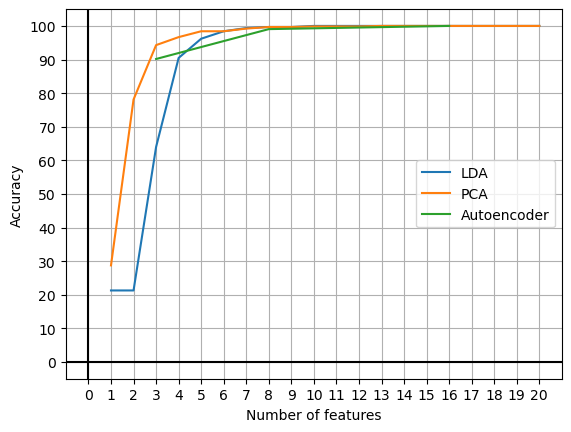

In [12]:
#Plotting all the accuracies
k = np.arange(1,21,1,dtype=int)
plt.plot(k,LDA_all_acc,label = "LDA")
plt.plot(k,PCA_all_acc,label = "PCA")
plt.plot(p,VAE_all_acc,label = "Autoencoder")

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xticks(range(0,21))
plt.yticks(range(0,110,10))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()